# Reto - Fases 3 y 4: Contagios considerando movimiento aleatorio
---

Modelación de sistemas con ecuaciones diferenciales

Equipo 8:


| Alumno | Matrícula |
| --- | --- |
| Juan Pablo Echeagaray González | A00830646 |
| Francisco García Barrada | A01735207 |
| Emmanuel Isaí Godínez Flores | A01612966 |
| Emanuel Park Kim | A00831441 |
| José Miguel Pérez Flores | A00832401 |

Profesores:

- Dr. Abraham Benito Barragán Amigón
- Dr. María Dolores García Martínez
  
3 de diciembre del 2021

## Librerías básicas

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')

# Versiones de las dependencias
print(f"""Dependencias:
python {sys.version}
numpy = {np.__version__}
pandas = {pd.__version__}
matplotlib = {mpl.__version__}
""")

Dependencias:
python 3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]
numpy = 1.20.3
pandas = 1.3.4
matplotlib = 3.4.2



## Método de RK4

Método de Runge-Kutta de orden 4 para resolver un sistema de ODEs (o una sola). Para fines educativos se ha diseñado esta implementación, pero es recomendable usar el método propio de alguna librería, como por ejemplo ['scipy.integrate.solve_ivp'](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). El usuario puede escojer qué método numérico utilizar dependiendo de sus necesidades de precisión.

In [2]:
def RK4(dfe, span: list, init: list, h=0.01) -> list:
    """## Método de RK4 para ODEs.

    ### Args:
        - dfe (function): Función que contenga el sistema de ODEs.
        - span (list): Rango de valores en los que se desea resolver el sistema.
        - init (list): Condiciones iniciales del sistema.
        - h (float): Tamaño de paso, debe de ser menor a 0.5 para que converja.

    ### Returns:
        - list: Regresa una lista de valores "t" y "y".
    """

    if np.ndim(init) == 0:
        m = 1
    else:
        m = len(init)

    t0 = span[0]
    tf = span[1]
    N = int((tf - t0) / h)
    t = np.zeros(N + 1)
    y = np.zeros([N + 1, m])
    t[0] = t0
    y[0, :] = init

    for i in range(N):
        k1 = dfe(t[i], y[i, :])
        k2 = dfe(t[i] + 0.5 * h, y[i, :] + 0.5 * h * k1)
        k3 = dfe(t[i] + 0.5 * h, y[i, :] + 0.5 * h * k2)
        k4 = dfe(t[i] + h, y[i, :] + h * k3)

        t[i + 1] = t[i] + h
        y[i + 1, :] = y[i, :] + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return t, y


## Posibles modelos

Para una documentación más profunda sobre el diseño y la selección de los parámetros de cada modelo, por favor consulte los reportes [1](https://github.com/JuanEcheagaray75/SIR-model/blob/master/reports/phase1.pdf) y [2](https://github.com/JuanEcheagaray75/SIR-model/blob/master/reports/phase2.pdf) de nuestro proyecto.

### Básico

$$
\begin{equation}
    \begin{gathered}
        \frac{dS}{dt}= -\beta \frac{I}{N} S\\
        \frac{dI}{dt}= \beta\frac{I}{N}S-\gamma I\\
        \frac{dR}{dt}= \gamma I
    \end{gathered}
\end{equation}
$$

In [3]:
def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    dydt = np.array([dS, dI, dR])
    return dydt

### Dinámica poblacional

$$
\begin{equation}
    \begin{gathered}
        \frac{dS}{dt} = -\beta \frac{I}{N} S + b N - \mu S \\
        \frac{dI}{dt} = \beta\frac{I}{N}S-\gamma I - \mu I\\
        \frac{dR}{dt} = \gamma I - \mu R
    \end{gathered}
\end{equation}
$$


In [4]:
def SIR_vital(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    N = S + I + R
    dS = - beta * I * S / N + b * N - mu * S
    dI = beta * I * S / N - gamma * I - mu * I
    dR = gamma * I - mu * R
    dydt = np.array([dS, dI, dR])
    return dydt


### Programa de vacunación

$$
\begin{equation}
    \begin{gathered}
        \frac{dS}{dt} = -\beta \frac{I}{N} S + (1 - v) N\\
        \frac{dI}{dt} = \beta\frac{I}{N}S - \gamma I \\
        \frac{dR}{dt} = \gamma I + v N
    \end{gathered}
\end{equation}
$$


In [5]:
def SIR_vaccine(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    N = S + I + R
    delta = beta * I * S / N
    dS = - delta + (1 - v) * N
    dI = delta - I * gamma
    dR = gamma * I + v * N
    dydt = np.array([dS, dI, dR])
    return dydt


## Funciones de apoyo

In [6]:
def resumen(ciudad: str, periodo: str, init: list, area: float, beta: float, gamma: float, mu: float, b: float):
    """Resumen de las condiciones iniciales del modelo.

    ### Args:
        - ciudad (str): Circular o cuadrada.
        - periodo (str): Unidad de tiempo usada.
        - init (list): Condiciones iniciales [S(0), I(0), R(0)].
        - area (float): Área en km2 de la ciudad.
        - beta (float): Razón de infección. (personas / unidad de tiempo)
        - gamma (float): Razón de recuperación. (personas / unidad de tiempo)
        - mu (float): Tasa de mortalidad. (personas / unidad de tiempo)
        - b (float): Tasa de natalidad. (personas / unidad de tiempo)
    """    

    print(f"""CIUDAD {ciudad}
Resumen de condiciones iniciales:
-------------------------------------
De la población general:
Área de la ciudad = {area:.2f} km^2
Densidad poblacional = {sum(init) / area:.2f} individuos/km^2
N = {sum(init)}
I0 = {init[1]}
S0 = {init[0]}
R0 = {init[2]}
Periodo de análisis = {tf} {periodo}
-------------------------------------
Del modelo básico:
beta = {beta}
gamma = {gamma}
-------------------------------------
Del modelo con dinámica poblacional:
b = {b}
mu = {mu}
-------------------------------------""")


In [7]:
def visualizar(t, y, ciudad: str, periodo: str, modelo: str, labels: list):
    """Función usada para visualizar las curvas de los modelos.

    ### Args:
        - t (list): Lista de valores de t sobre los que se graficará.
        - y (list): Valores de y a graficar.
        - ciudad (str): Ciudad del modelo.
        - periodo (str): Unidad de tiempo usada.
        - modelo (str): Circular o cuadrada.
        - labels (list): Etiquetas para cada una de las curvas.
    """    
    plt.figure(figsize=(10, 6))
    plt.plot(t, y[:, 0], label=labels[0])
    plt.plot(t, y[:, 1], label=labels[1])
    plt.plot(t, y[:, 2], label=labels[2])
    plt.xlabel(f'Tiempo {periodo}')
    plt.ylabel('Población')
    plt.title(f'CIUDAD {ciudad} - {modelo}')
    plt.legend()
    plt.show()


## Generación de distribuciones

Se propone una población inicial de tamaño $N$, un radio de infección en $km$, y se inicializa el número de infectados $I_0$ como 1 para todos los casos, esto facilita la generación de las primeras distribuciones de la población.

In [8]:
N = 50_000
INFECTION_RADIUS = 20e-3
I0 = 1

### Ciudad cuadrada

In [9]:
# Propiedades de la ciudad
L = 1

# Diseño de la ciudad
x0, y0 = 0, 0
square = plt.Rectangle((x0, y0), L,
                       L, fill=False, ec='black')

# Generación de puntos aleatorios con distribución uniforme (dentro de los bordes)
x = np.random.uniform(0, L, N)
y = np.random.uniform(0, L, N)

# Cálculo de infectados iniciales
df = pd.DataFrame({'x': x, 'y': y})
df['Estado'] = 0
df.loc[np.random.choice(df.index, int(I0)), 'Estado'] = 1
infected_pos = np.array(df.loc[df['Estado'] == 1, ['x', 'y']])
# Plot the position of the patient 0
df['Distance_I0'] = (df[['x', 'y']] - infected_pos).pow(2).sum(1).pow(0.5)

# Cambio de estado si están suficientemente cerca al paciente 0
df.loc[df['Distance_I0'] <= INFECTION_RADIUS, 'Estado'] = 1
new_I0 = len(df.loc[df['Estado'] == 1])
print(f'Nuevos infectados: {new_I0} individuos')

Nuevos infectados: 66 individuos


#### Distribución inicial

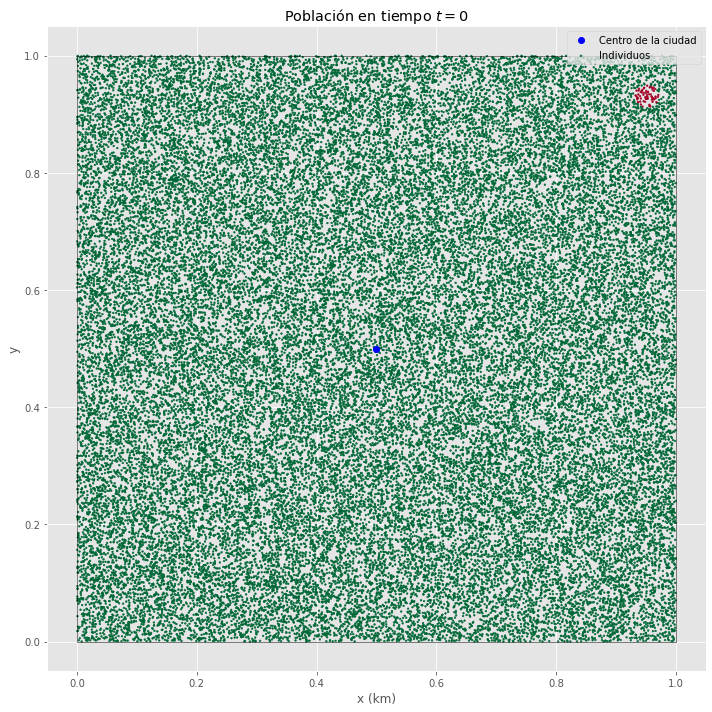

In [10]:
# Visualización del estado inicial del sistema
plt.figure(figsize=(10, 10))
plt.scatter(infected_pos[:, 0], infected_pos[:, 1], c='k', s=1)
plt.scatter(x, y, s=3, label='Individuos', c=df['Estado'], cmap='RdYlGn_r')
plt.plot(x0 + 0.5 * L, y0 + 0.5 * L, 'bo', label='Centro de la ciudad')
plt.gca().add_patch(square)
plt.xlabel('x (km)')
plt.ylabel('y')
plt.title(r'Población en tiempo $t = 0$')
plt.legend()
plt.tight_layout()
plt.show()

Se ha designado el código de colores siguiente:
- Verde $\rightarrow$ Susceptible
- Rojo $\rightarrow$ Infectado

### Condiciones iniciales

In [11]:
I0 = int(new_I0)
S0 = N - I0
R0 = 0
init = [S0, I0, R0]
t0 = 0
tf = 30
span = [t0, tf]

# Modelo básico
beta = 1
gamma = 0.1

# Modelo con dinámica poblacional
b = 1 / (70 * 365)
mu = 1 / (70 * 365)

resumen('CUADRADA', 'días', init, L * L, beta, gamma, mu, b)

CIUDAD CUADRADA
Resumen de condiciones iniciales:
-------------------------------------
De la población general:
Área de la ciudad = 1.00 km^2
Densidad poblacional = 50000.00 individuos/km^2
N = 50000
I0 = 66
S0 = 49934
R0 = 0
Periodo de análisis = 30 días
-------------------------------------
Del modelo básico:
beta = 1
gamma = 0.1
-------------------------------------
Del modelo con dinámica poblacional:
b = 3.913894324853229e-05
mu = 3.913894324853229e-05
-------------------------------------


### Ejecución del algoritmo

In [12]:
t_normal, y_normal = RK4(SIR, span, init)
t_vital, y_vital = RK4(SIR_vital, span, init)

El caso del modelo que incluye vacunas es más complicado que los anteriores, ya que para visualizar mejor el efecto que un programa de vacunación puede tener, deben de analizarse periodos de tiempo más largos. Estamos proponiendo que el análisis se haga durante un periodo de 1 año.

In [13]:
t0 = 0
tf = 1
span = [t0, tf]
beta = 0.4 * 365
gamma = 0.1 * 365
mu = b
v = 1 - gamma / beta
print(f'% Vacunaciones = {v * 100:.2f} %')

% Vacunaciones = 75.00 %


In [14]:
t_vaccine, y_vaccine = RK4(SIR_vaccine, span, init)

#### Respaldo de resultados

In [15]:
dfnormal = pd.DataFrame(np.array(y_normal), columns=['S', 'I', 'R'], index=t_normal)
dfvital = pd.DataFrame(np.array(y_vital), columns=['S', 'I', 'R'], index=t_vital)
dfvaccine = pd.DataFrame(np.array(y_vaccine), columns=['S', 'I', 'R'], index=t_vaccine)

# Respaldo a csv
dfnormal.to_csv('data\\fase3_4\\dfnormal_square.csv')
dfvital.to_csv('data\\fase3_4\\dfvital_square.csv')
dfvaccine.to_csv('data\\fase3_4\\dfvaccine_square.csv')

#### Máximos números de infectados y reducción de susceptibles a la mitad

In [16]:
# Días de máximos infectados
max_infected = dfnormal['I'].max()
day_max = dfnormal['I'].idxmax()
max_infected_vital = dfvital['I'].max()
day_max_vital = dfvital['I'].idxmax()
max_infected_vaccine = dfvaccine['I'].max()
day_max_vaccine = dfvaccine['I'].idxmax()

# Reducción de infectados a la mitad
half_sup = 0.5 * dfnormal['S'].max()
day_half_sup = dfnormal['S'].loc[dfnormal['S'] >= half_sup].idxmin()
half_sup_vital = 0.5 * dfvital['S'].max()
day_half_sup_vital = dfvital['S'].loc[dfvital['S'] >= half_sup_vital].idxmin()
half_sup_vaccine = 0.5 * dfvaccine['S'].max()
day_half_sup_vaccine = dfvaccine['S'].loc[dfvaccine['S'] >= half_sup_vaccine].idxmin()

print(f"""Tiempos máximos de infección:
-------------------------------------
Modelo básico:
Día máximo de infección = {day_max:.0f}
Número de infectados máximos = {max_infected:.0f}
-------------------------------------
Modelo con dinámica poblacional:
Día máximo de infección = {day_max_vital:.0f}
Número de infectados máximos = {max_infected_vital:.0f}
-------------------------------------
Modelo con vacunación:
Año máximo de infección = {day_max_vaccine}
Número de infectados máximos = {max_infected_vaccine:.0f}
-------------------------------------
Reducción de infectados a la mitad:
Modelo básico: {day_half_sup:.0f} (días)
Modelo con dinámica poblacional: {day_half_sup_vital:.0f} (días)
Modelo con vacunación: {day_half_sup_vaccine} (años)
------------------------------------""")

Tiempos máximos de infección:
-------------------------------------
Modelo básico:
Día máximo de infección = 10
Número de infectados máximos = 33494
-------------------------------------
Modelo con dinámica poblacional:
Día máximo de infección = 10
Número de infectados máximos = 33492
-------------------------------------
Modelo con vacunación:
Año máximo de infección = 0.07
Número de infectados máximos = 19407
-------------------------------------
Reducción de infectados a la mitad:
Modelo básico: 7 (días)
Modelo con dinámica poblacional: 7 (días)
Modelo con vacunación: 0.060000000000000005 (años)
------------------------------------


### Visualización de resultados

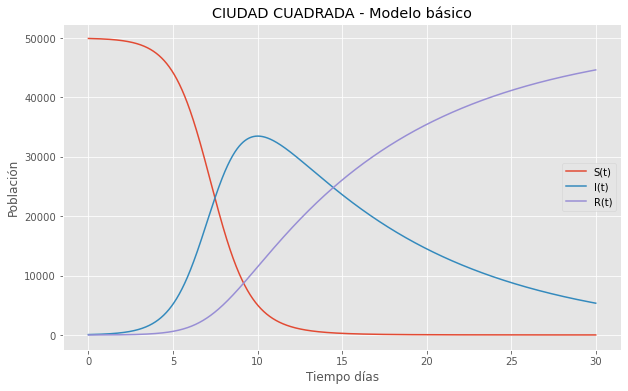

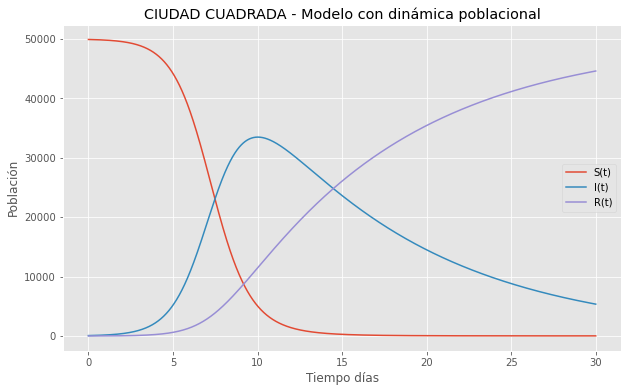

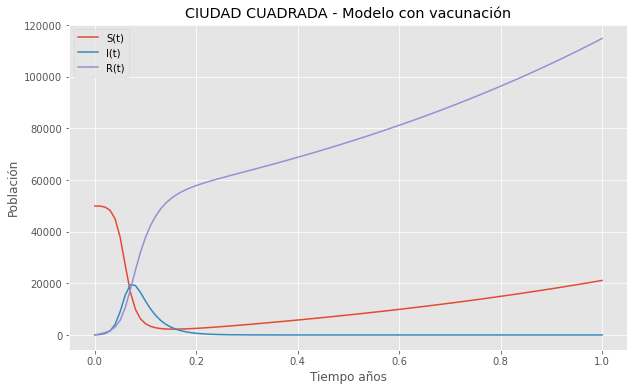

In [17]:
ciudad = 'CUADRADA'
modelo = ['Modelo básico', 'Modelo con dinámica poblacional', 'Modelo con vacunación']
labels = ['S(t)', 'I(t)', 'R(t)']
period = 'días'

visualizar(t_normal, y_normal, ciudad, period, modelo[0], labels)
visualizar(t_vital, y_vital, ciudad, period, modelo[1], labels)
visualizar(t_vaccine, y_vaccine, ciudad, 'años', modelo[2], labels)


### Ciudad circular

In [18]:
# Debe redefinirse el valor inicial de I0
I0 = 1

In [19]:
# Bordes de la ciudad
theta = np.linspace(0, 2 * np.pi, 100)
r = 1 # km
x0, y0 = 0, 0
x = x0 + r * np.cos(theta)
y = y0 + r * np.sin(theta)

# Generación de puntos uniformemente distribuidos en el círculo
R = np.sqrt(np.random.rand(N)) * r
theta = 2 * np.pi * np.random.rand(N)
x_circle = R * np.cos(theta)
y_circle = R * np.sin(theta)

# Cálculo de individuos infectados iniciales
df_circle = pd.DataFrame({'x_circle': x_circle, 'y_circle': y_circle})
df_circle['Estado'] = 0
df_circle.loc[np.random.choice(df_circle.index, int(I0)), 'Estado'] = 1
infected_pos = np.array(df_circle.loc[df_circle['Estado'] == 1, ['x_circle', 'y_circle']])
# Plot the position of the patient 0
df_circle['Distance_I0'] = (df_circle[['x_circle', 'y_circle']] - infected_pos).pow(2).sum(1).pow(0.5)

# Cambio de estado si están suficientemente cerca al paciente 0
df_circle.loc[df_circle['Distance_I0'] <= INFECTION_RADIUS, 'Estado'] = 1
new_I0 = len(df_circle.loc[df_circle['Estado'] == 1])
print(f'Nuevos infectados: {new_I0}')

Nuevos infectados: 22


#### Distribución inicial

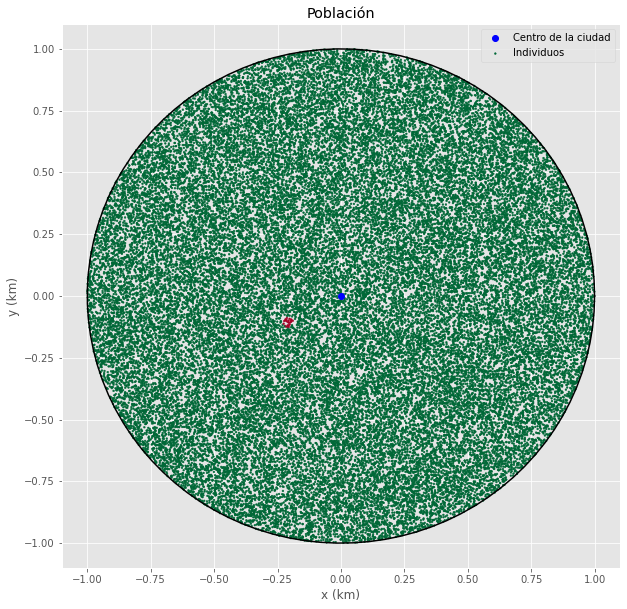

In [20]:
# Visualización de la distribución
plt.figure(figsize=(10, 10))
plt.scatter(infected_pos[:, 0], infected_pos[:, 1], c='k', s=1)
plt.scatter(x_circle, y_circle, s=3, label='Individuos', c=df_circle['Estado'], cmap='RdYlGn_r')
plt.plot(x0, y0, 'bo', label='Centro de la ciudad')
plt.plot(x, y, 'k-')
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Población')
plt.legend()
plt.show()

### Condiciones iniciales

In [21]:
I0 = int(new_I0)
S0 = N - I0
R0 = 0
init = [S0, I0, R0]
t0 = 0
tf = 30
span = [t0, tf]

# Modelo básico
beta = 1
gamma = 0.1

# Modelo con dinámica poblacional
b = 1 / (70 * 365)
mu = 1 / (70 * 365)

resumen('CIRCULAR', 'días', init, np.pi * r ** 2, beta, gamma, mu, b)

CIUDAD CIRCULAR
Resumen de condiciones iniciales:
-------------------------------------
De la población general:
Área de la ciudad = 3.14 km^2
Densidad poblacional = 15915.49 individuos/km^2
N = 50000
I0 = 22
S0 = 49978
R0 = 0
Periodo de análisis = 30 días
-------------------------------------
Del modelo básico:
beta = 1
gamma = 0.1
-------------------------------------
Del modelo con dinámica poblacional:
b = 3.913894324853229e-05
mu = 3.913894324853229e-05
-------------------------------------


### Ejecución del algoritmo

In [22]:
t_normal_circle, y_normal_circle = RK4(SIR, span, init)
t_vital_circle, y_vital_circle = RK4(SIR_vital, span, [S0, I0, R0])

In [23]:
t0 = 0
tf = 1
span = [t0, tf]
beta = 0.4 * 365
gamma = 0.1 * 365
mu = b
v = 1 - gamma / beta
print(f'% Vacunaciones = {v * 100:.2f} %')

% Vacunaciones = 75.00 %


In [24]:
t_vaccine_circle, y_vaccine_circle = RK4(SIR_vaccine, span, init)

In [25]:
dfnormal_circle = pd.DataFrame(np.array(y_normal_circle), columns=['S', 'I', 'R'], index=t_normal_circle)
dfvital_circle = pd.DataFrame(np.array(y_vital_circle), columns=['S', 'I', 'R'], index=t_vital_circle)
dfvaccine_circle = pd.DataFrame(np.array(y_vaccine_circle), columns=['S', 'I', 'R'], index=t_vaccine_circle)

# Respaldo a csv
dfnormal_circle.to_csv('data\\fase3_4\\dfnormal_circle.csv')
dfvital_circle.to_csv('data\\fase3_4\\dfvital_circle.csv')
dfvaccine_circle.to_csv('data\\fase3_4\\dfvaccine_circle.csv')

In [26]:
# Máximo número de infectados
max_infected_normal_circle = dfnormal_circle['I'].max()
day_max_normal_circle = dfnormal_circle['I'].idxmax()
max_infected_vital_circle = dfvital_circle['I'].max()
day_max_vital_circle = dfvital_circle['I'].idxmax()
max_infected_vaccine_circle = dfvaccine_circle['I'].max()
day_max_vaccine_circle = dfvaccine_circle['I'].idxmax()

# Reducción de susceptibles a la mitad
half_sup_circle = 0.5 * dfnormal_circle['S'].max()
day_half_sup_circle = dfnormal_circle['S'].loc[dfnormal_circle['S'] >= half_sup_circle].idxmin()
half_sup_vital_circle = 0.5 * dfvital_circle['S'].max()
day_half_sup_vital_circle = dfvital_circle['S'].loc[dfvital_circle['S'] >= half_sup_vital_circle].idxmin()
half_sup_vaccine_circle = 0.5 * dfvaccine_circle['S'].max()
day_half_sup_vaccine_circle = dfvaccine_circle['S'].loc[dfvaccine_circle['S'] >= half_sup_vaccine_circle].idxmin()


print(f"""Tiempos máximos de infección
-------------------------------------
Modelo básico:
Día máximo de infección = {day_max_normal_circle:.0f}
Número de infectados máximos = {max_infected_normal_circle:.0f}
-------------------------------------
Modelo con dinámica poblacional:
Día máximo de infección = {day_max_vital_circle:.0f}
Número de infectados máximos = {max_infected_vital_circle:.0f}
-------------------------------------
Modelo con vacunación:
Año máximo de infección = {day_max_vaccine_circle}
Número de infectados máximos = {max_infected_vaccine_circle:.0f}
-------------------------------------
Reducción de infectados a la mitad:
Modelo básico: {day_half_sup_circle:.0f} (días)
Modelo con dinámica poblacional: {day_half_sup_vital_circle:.0f} (días)
Modelo con vacunación: {day_half_sup_vaccine_circle} (años)
------------------------------------""")

Tiempos máximos de infección
-------------------------------------
Modelo básico:
Día máximo de infección = 11
Número de infectados máximos = 33489
-------------------------------------
Modelo con dinámica poblacional:
Día máximo de infección = 11
Número de infectados máximos = 33488
-------------------------------------
Modelo con vacunación:
Año máximo de infección = 0.09
Número de infectados máximos = 19231
-------------------------------------
Reducción de infectados a la mitad:
Modelo básico: 9 (días)
Modelo con dinámica poblacional: 9 (días)
Modelo con vacunación: 0.07 (años)
------------------------------------


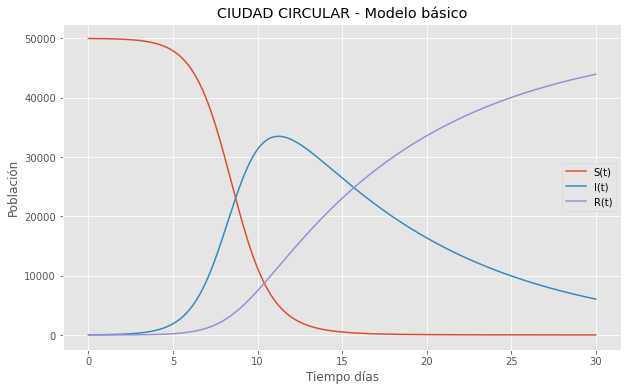

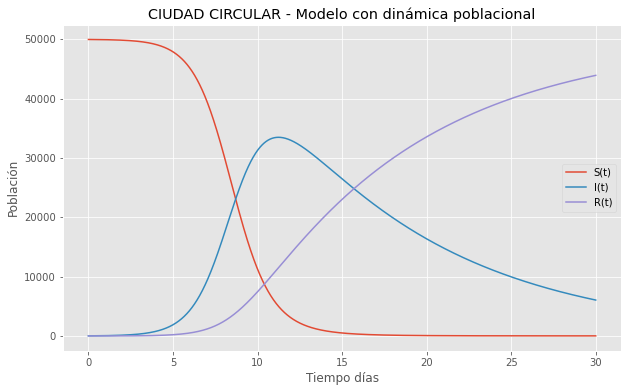

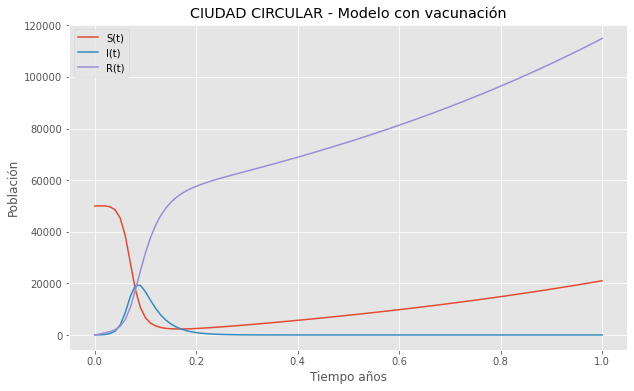

In [27]:
ciudad = 'CIRCULAR'
modelo = ['Modelo básico', 'Modelo con dinámica poblacional', 'Modelo con vacunación']
labels = ['S(t)', 'I(t)', 'R(t)']
period = 'días'

visualizar(t_normal_circle, y_normal_circle, ciudad, period, modelo[0], labels)
visualizar(t_vital_circle, y_vital_circle, ciudad, period, modelo[1], labels)
visualizar(t_vaccine_circle, y_vaccine_circle, ciudad, 'años', modelo[2], labels)